In [1]:
library(ggplot2)
library(reshape2)
library(cowplot)
library(dplyr)
library(ggridges)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘ggridges’

The following object is masked from ‘package:ggplot2’:

    scale_discrete_manual



In [2]:
site = "all" #all, subg, supg, tongue

md <- read.table("data/METADATA.txt", header=TRUE, comment.char="", row.names=1)
tax <- read.table("data/indicator_taxonomy.tsv",sep="\t",header=1)
rownames(tax) <- tax$Feature.ID

purify_taxa <- function(taxon_list) {
    taxon_list <- gsub("D_7__;D_8__;D_9__;D_10__;D_11__;D_12__;D_13__;D_14__;D_15__;D_16__", "", taxon_list)
    for (i in 1:length(taxon_list)){
       x<-unlist(strsplit(as.character(taxon_list[i]),";"))
    #    if (length(x)>0) {
       if (grepl("uncultured", x[length(x)])) {
         x<-x[length(x)-1]
       } else {
         x<-x[length(x)]
       }
    #}
           taxon_list[i] <- gsub("D_[1-6]__", "", x[length(x)])
        
    }
    taxon_list
}

read_and_normalize <- function(site) {
    if (site == 'all') {
        rows <- rownames(md)
    } else {
        rows <- rownames(md)[md$Site==site]
    }
    #Switch these to swap between the full and rarefied tables
    #Using the full table for graphics in manuscript
    #ctab <- read.table(paste("data/", site, "-rarefied-asv-tab.tsv",sep=""),row.names=1,sep="\t",header=1, comment.char="",skip=1)
    ctab <- read.table(paste("data/asv-table-full.tsv",sep=""),row.names=1,sep="\t",header=1, comment.char="",skip=1)
    ctab <- scale(ctab, center=FALSE, scale=colSums(ctab))
    ctab <- ctab[,rows]
    ctab
}

get_indicator_counts <- function(site) {
    if (site == 'all') {
        rows <- rownames(md)
    } else {
        rows <- rownames(md)[md$Site==site]
    }
    dd <- read.table(paste("data/indicator_Type_", site, ".tsv", sep=""),header=1)
    indicators <- gsub('^X', '', dd[,1])
    taxa <- tax[indicators,]
    taxa$Taxon <- purify_taxa(taxa$Taxon)
    ctab <- read_and_normalize(site)
    mtab <- merge(ctab, taxa, by = 0)
    mtab <- melt(mtab[,c("Feature.ID","Taxon",rows)])
    mtab$Site <- md[as.vector(mtab$variable),"Site"]
    mtab$Type <- md[as.vector(mtab$variable),"Type"]
    mtab$value <- mtab$value #Add pseudocount for logging later
    mtab
}

get_taxon_counts <- function(tax_str, site) {
    if (site == 'all') {
        rows <- rownames(md)
    } else {
        rows <- rownames(md)[md$Site==site]
    }
    taxa <- grep(tax_str,tax$Taxon)
    taxa <- tax[taxa,]
    taxa$Taxon <- purify_taxa(taxa$Taxon)
    ctab <- read_and_normalize(site)
    mtab <- merge(ctab, taxa, by = 0)
    mtab <- melt(mtab[,c("Feature.ID","Taxon",rows)])
    mtab$Site <- md[as.vector(mtab$variable),"Site"]
    mtab$Type <- md[as.vector(mtab$variable),"Type"]
    mtab
}

plot_combined_indicators <- function(tax_str, site) {
    query <- get_indicator_counts(site)
    query <- query[grep(tax_str, query$Taxon),]
    aquery <- aggregate(query$value, by=list(query$variable), FUN=sum)
    names(aquery) <- c("variable", "value")
    aquery$Type <- md[as.vector(aquery$variable), "Type"]
    ggplot(aquery, aes(x=value, y=Type, fill=Type)) +
    scale_fill_brewer(palette = "Dark2") + geom_density_ridges() + #geom_point() + geom_boxplot(alpha=0.7, outlier.shape=NA) +
    theme(axis.text.x  = element_text(angle=45, hjust = 1, vjust = 1), legend.position = "none") + 
    xlab("Relative Abundance") +ggtitle(tax_str)
    
}

plot_indicators <- function(tax_str, site, id=FALSE) {
    query <- get_indicator_counts(site)
    query <- query[grep(tax_str, query$Taxon),]
    class_lab <- query$Taxon
    names(class_lab) <- query$Feature.ID
    #ggplot(query, aes(x=Type, y=value, colour=Type)) + 
    ggplot(query, aes(x=value, y=Type, fill=Type)) +
    scale_fill_brewer(palette = "Dark2") + geom_density_ridges() + #geom_point() + geom_boxplot(alpha=0.7, outlier.shape=NA) +
   facet_wrap(vars(Feature.ID), scale='free_x', labeller=labeller(Feature.ID = class_lab)) +
    theme(axis.text.x  = element_text(angle=45, hjust = 1, vjust = 1), legend.position = "none") + 
    xlab("Relative Abundance")
}

plot_taxa <- function(tax_str, site) {
    query <- get_taxon_counts(tax_str, site)
    aquery <- aggregate(query$value, by=list(query$variable), FUN=sum)
    names(aquery) <- c("variable", "value")
    aquery$Type <- md[as.vector(aquery$variable), "Type"]
    aquery$Site <- md[as.vector(aquery$variable), "Site"]
    sites <- c("Subgingival", "Supragingival", "Tongue")
    short_sites <- c("subg", "supg", "tongue")
    names(sites) <- short_sites
    ggplot(aquery, aes(x=log1p(value), y=Type, fill=Type)) + stat_density_ridges(quantile_lines = TRUE, alpha=0.7) + #+ geom_point(position='jitter') + geom_boxplot(alpha=0.7, outlier.shape=NA) +
    scale_fill_brewer(palette = "Dark2") + ggtitle(tax_str) +
    theme(axis.text.x  = element_text(angle=45, hjust = 1, vjust = 1), legend.position = "none") +
    ylab("") + xlab("") + facet_grid(cols = vars(Site), scale="free_x", labeller=labeller(Site = sites))
}

## Figure 3
### Taxa abundances by sequencing

In [3]:
tf <- plot_taxa('Tannerella', 'all') + scale_fill_grey()
p <- plot_taxa('Porphyromonas', 'all') + scale_fill_grey()
pe <- plot_taxa('Porphyromonas endodontalis', 'all')
a <- plot_taxa('Actinomyces', 'all') + scale_fill_grey()
s <- plot_taxa('Streptococcus', 'all') + scale_fill_grey()
k <- plot_taxa('Kingella', 'all') + scale_fill_grey()
trep<-plot_taxa('Treponema', 'all') + scale_fill_grey()
syn<-plot_taxa('Synergistaceae', 'all')
fn<-plot_taxa('Fusobacterium nucleatum', 'all')
ap<-plot_taxa('Alloprevotella', 'all')
pr<-plot_taxa('Prevotella', 'all')
lep<-plot_taxa('Leptotrichia', 'all')
la<-plot_taxa('Lachnoanaerobaculum', 'all')
stom<-plot_taxa('Stomatobaculum', 'all')
lb<-plot_taxa('Lactobacillales', 'all')
n<-plot_taxa('Neisseria$', 'all')
td <- plot_taxa('Treponema denticola', 'all')
ts<-plot_taxa('Treponema socranskii', 'all')

Using Feature.ID, Taxon as id variables
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Using Feature.ID, Taxon as id variables
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Using Feature.ID, Taxon as id variables
Using Feature.ID, Taxon as id variables
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Using Feature.ID, Taxon as id variables
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Using Feature.ID, Taxon as id variables
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Using Feature.ID, Taxon as id variables
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.
Using Feature.ID, Taxon as id variables
Using Feature.ID, Taxon as

Picking joint bandwidth of 0.00477
Picking joint bandwidth of 0.00304
Picking joint bandwidth of 0.000777
Picking joint bandwidth of 0.00617
Picking joint bandwidth of 0.00831
Picking joint bandwidth of 0.000203
Picking joint bandwidth of 0.00282
Picking joint bandwidth of 0.00304
Picking joint bandwidth of 0.000446
Picking joint bandwidth of 0.0324
Picking joint bandwidth of 0.0432
Picking joint bandwidth of 0.0219
Picking joint bandwidth of 0.0153
Picking joint bandwidth of 0.00552
Picking joint bandwidth of 0.00501
Picking joint bandwidth of 0.0151
Picking joint bandwidth of 0.0157
Picking joint bandwidth of 0.0276


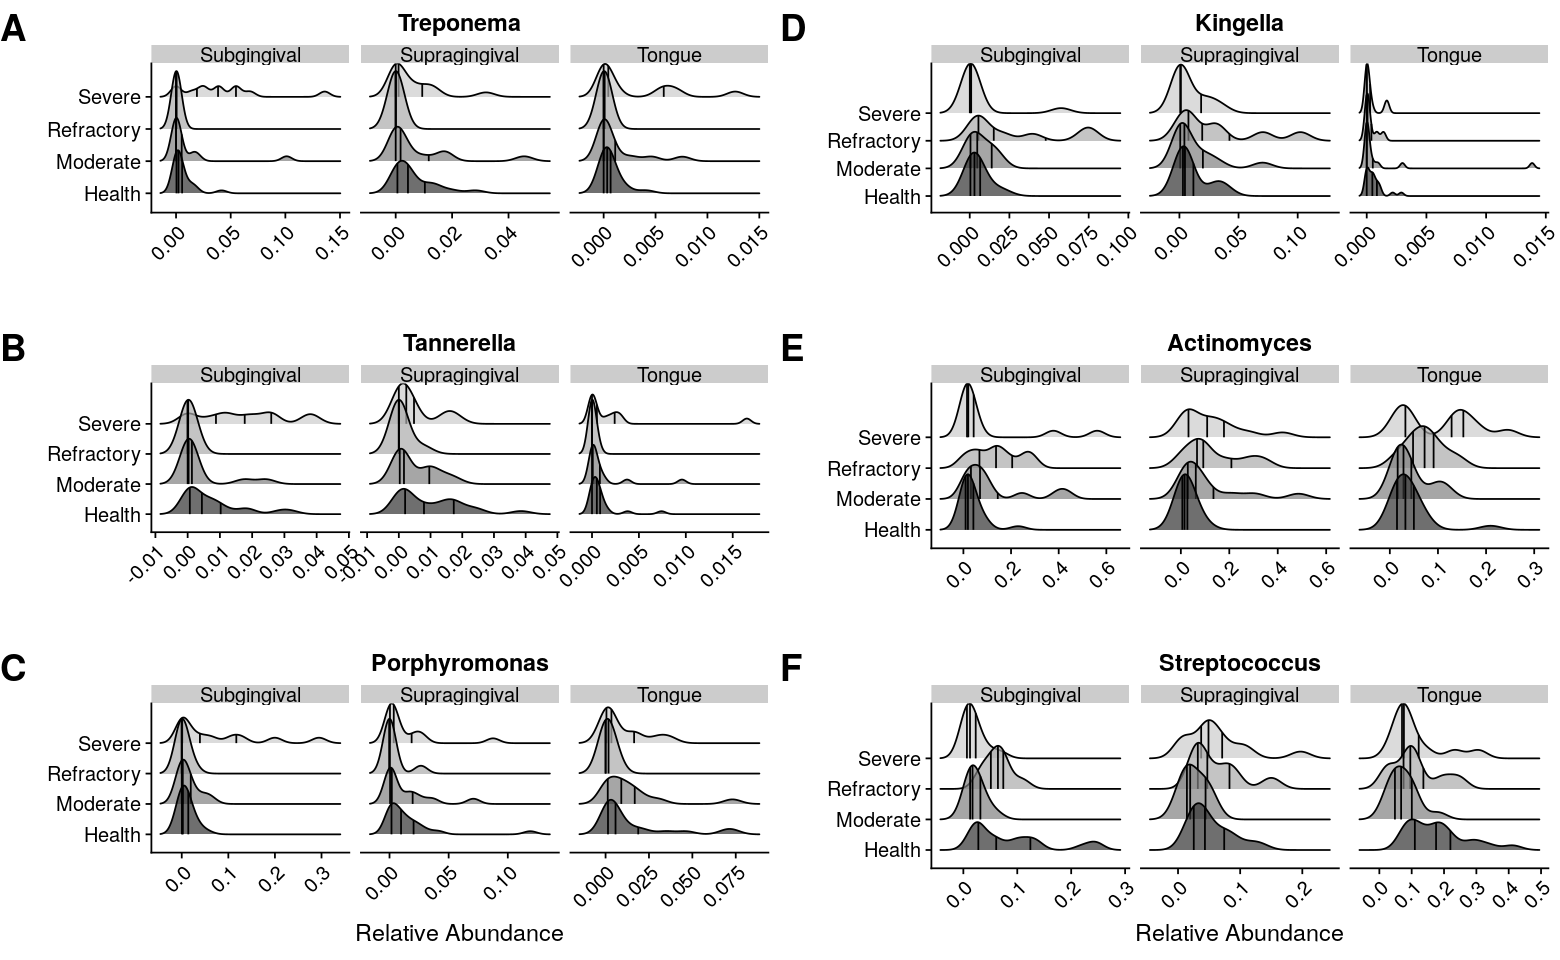

In [4]:
#pdf("Figure3.pdf",width=13, height=8)
options(repr.plot.width=13, repr.plot.height=8)
plot_grid(trep, k,
          tf, a,
          p+xlab("Relative Abundance"), s+xlab("Relative Abundance"),
          labels = c("A", "D", "B", "E", "C", "F"), ncol=2, hjust=0, label_size=22)
#dev.off()

Picking joint bandwidth of 0.00155
Picking joint bandwidth of 0.00162
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.016
Picking joint bandwidth of 0.0173
Picking joint bandwidth of 0.032
Picking joint bandwidth of 0.00127
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.000112
Picking joint bandwidth of 0.00168
Picking joint bandwidth of 0.00315
Picking joint bandwidth of 0.003
Picking joint bandwidth of 0.00684
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.000163
Picking joint bandwidth of 0.00779
Picking joint bandwidth of 0.0171
Picking joint bandwidth of 0.0532
Picking joint bandwidth of 0.0431
Picking joint bandwidth of 0.0476
Picking joint bandwidth of 0.00474
Picking joint bandwidth of 0.0178
Picking joint bandwidth of 0.0128
Picking joint bandwidth of 0.0415
Picking joint bandwidth of 0.00226
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.00158
Picking joint bandwidth of 0.000742
Pickin

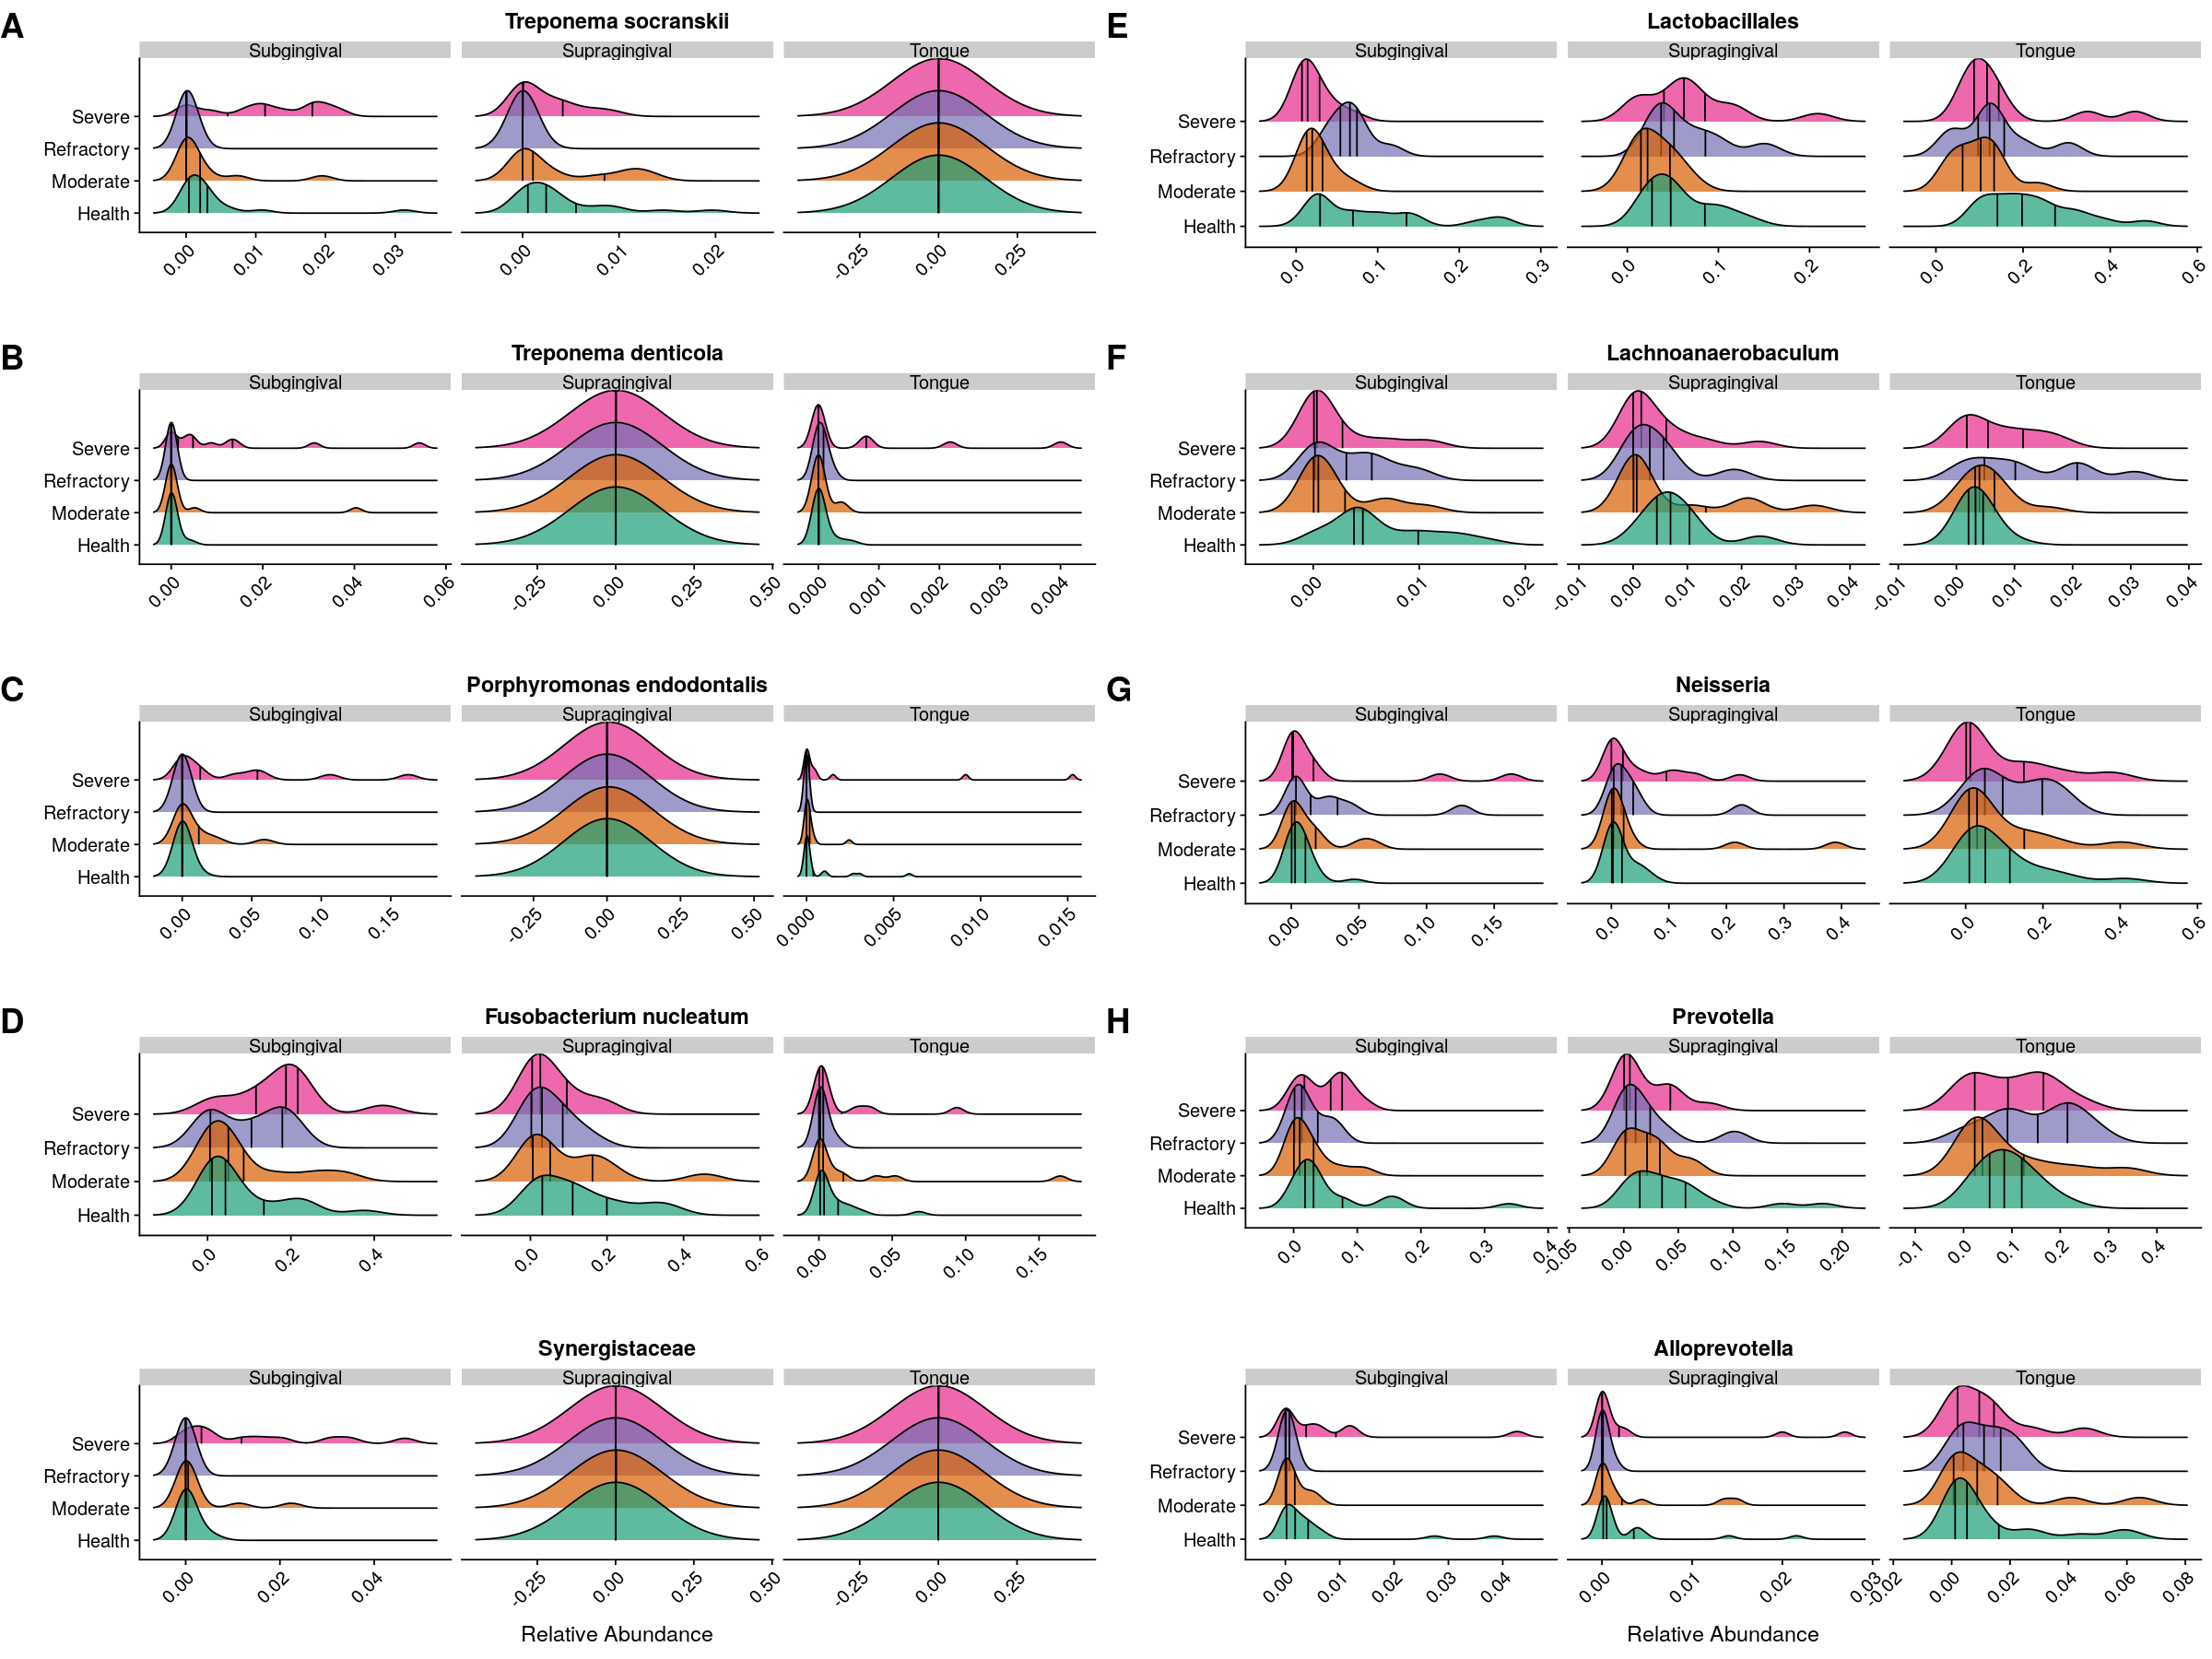

In [5]:
options(repr.plot.width=20, repr.plot.height=15)
plot_grid(ts,lb,
          td,la,
          pe,n+ggtitle("Neisseria"), #Have to search Neisseria$ to make sure we don't get Neisseriaceae etc.
          fn,pr,
          syn+xlab("Relative Abundance"),ap+xlab("Relative Abundance"),
          labels = c("A", "E", "B", "F", "C", "G", "D", "H"), ncol=2, hjust=0, label_size=22)

## Supplementary Sequence Abundance Plots

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00742
Picking joint bandwidth of 0.00937
Picking joint bandwidth of 0.000366


Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.0469
Picking joint bandwidth of 0.0516
Picking joint bandwidth of 0.0198


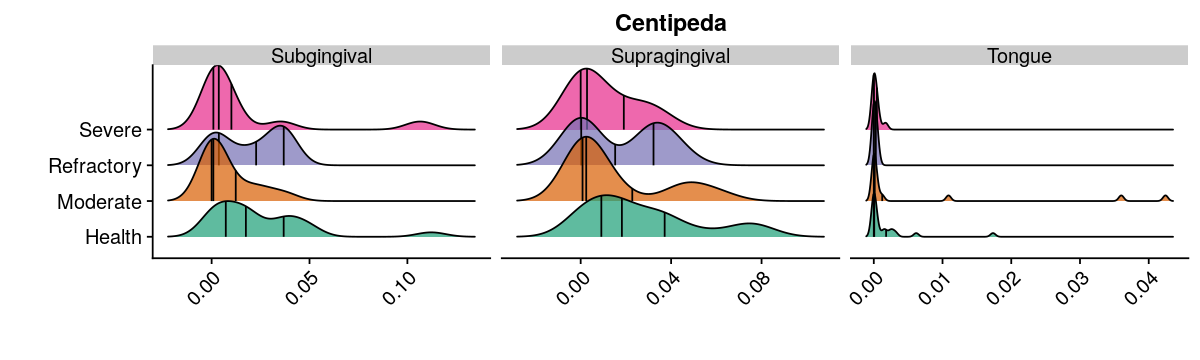

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00128
Picking joint bandwidth of 0.00076
Picking joint bandwidth of 0.000127


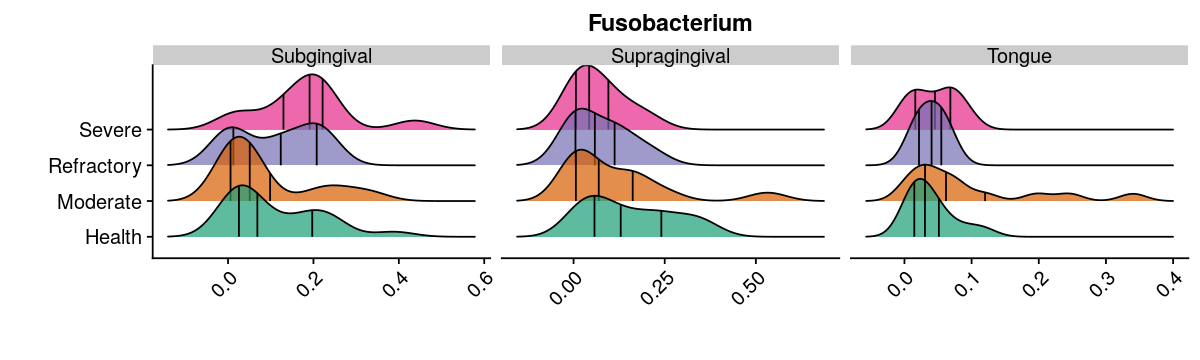

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000971
Picking joint bandwidth of 0.000409
Picking joint bandwidth of 0.000502


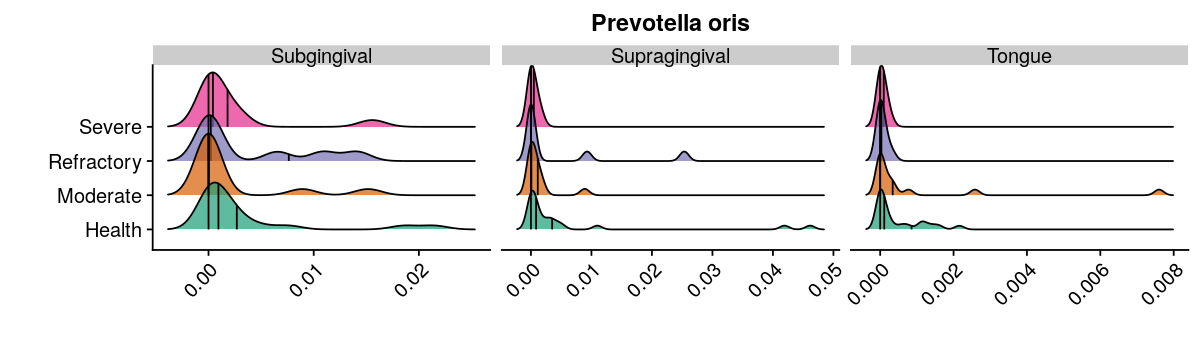

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00084
Picking joint bandwidth of 0.000344
Picking joint bandwidth of 0.000502


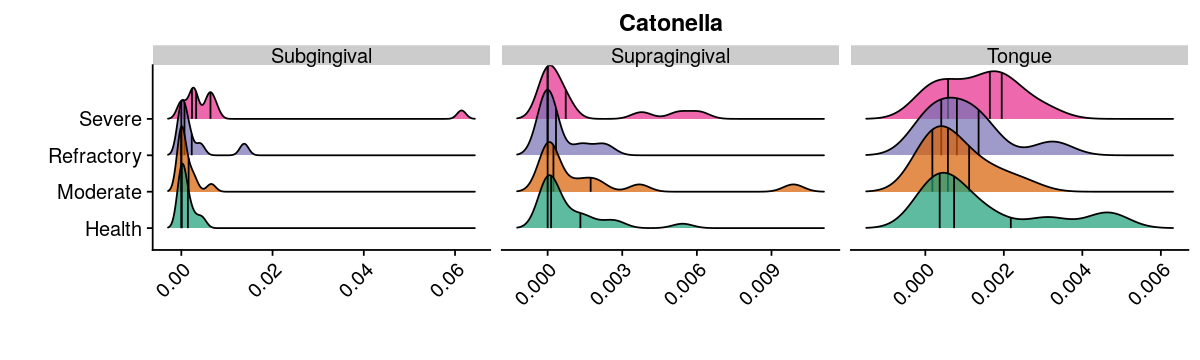

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.0571
Picking joint bandwidth of 0.0526
Picking joint bandwidth of 0.0314


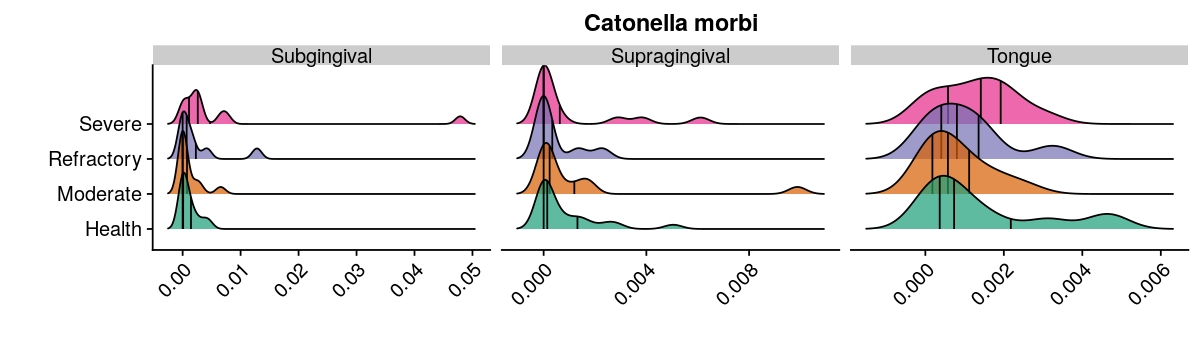

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000167
Picking joint bandwidth of 0.000131
Picking joint bandwidth of 0.00142


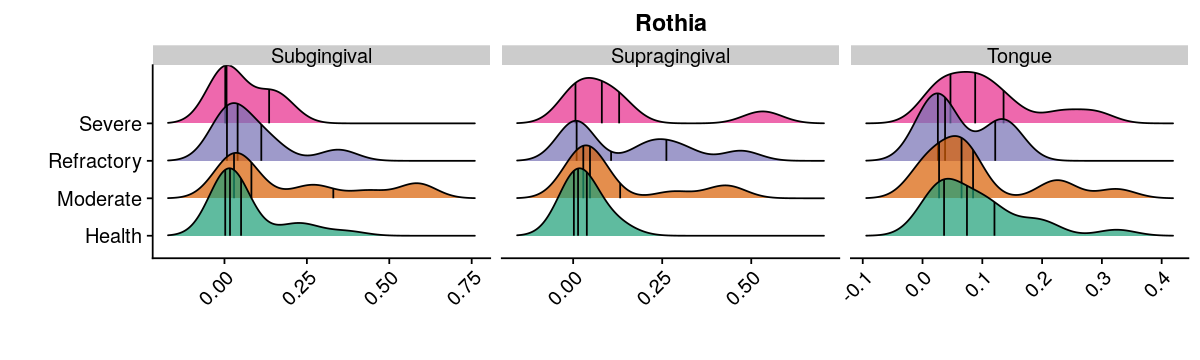

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.0148
Picking joint bandwidth of 0.0169
Picking joint bandwidth of 0.0333


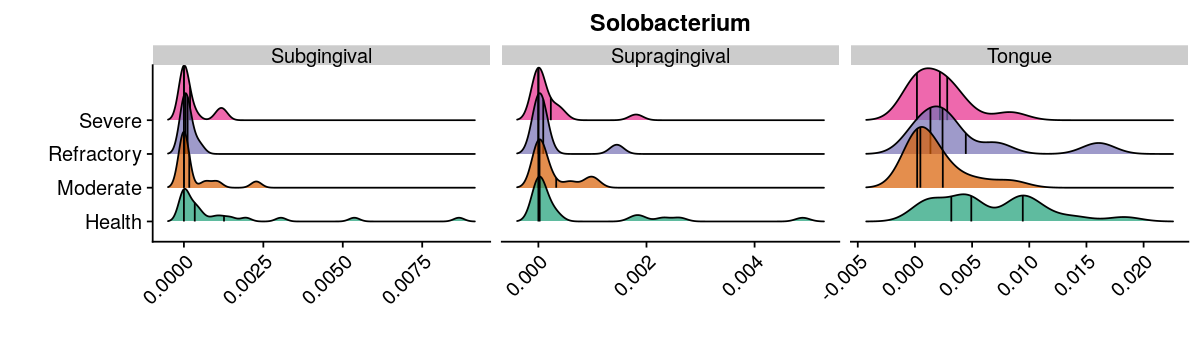

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00141
Picking joint bandwidth of 0.00145
Picking joint bandwidth of 0.000625


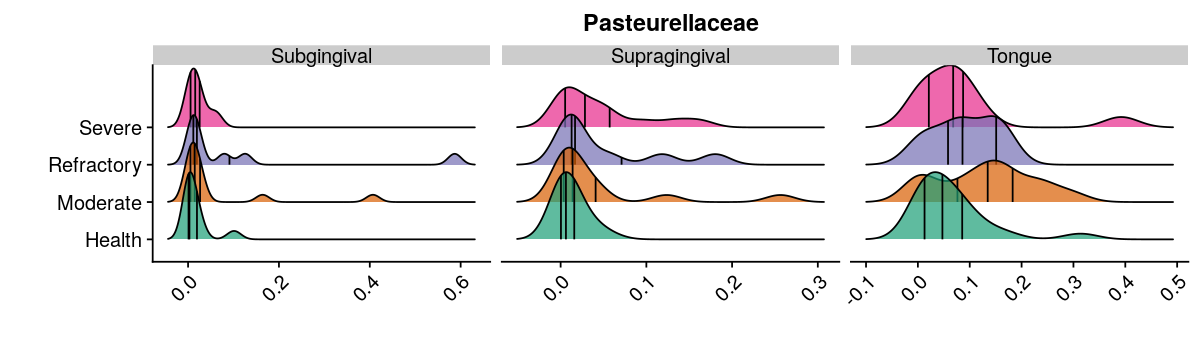

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00228
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.149


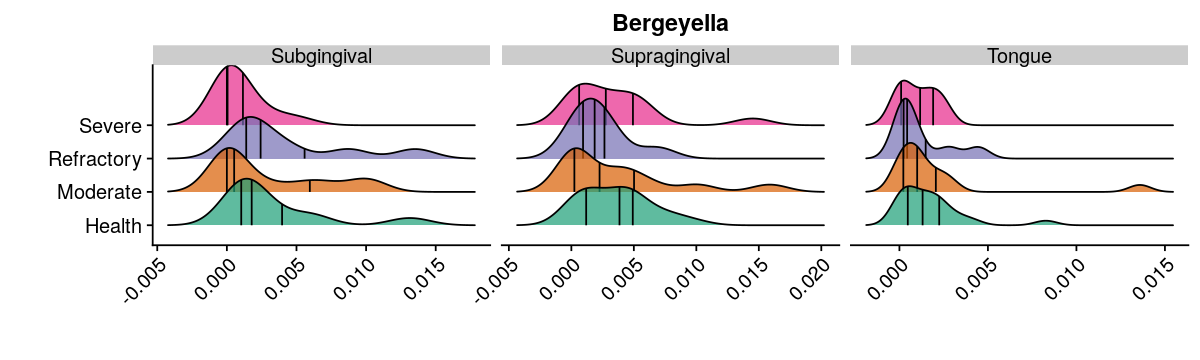

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00245
Picking joint bandwidth of 0.00233
Picking joint bandwidth of 0.000144


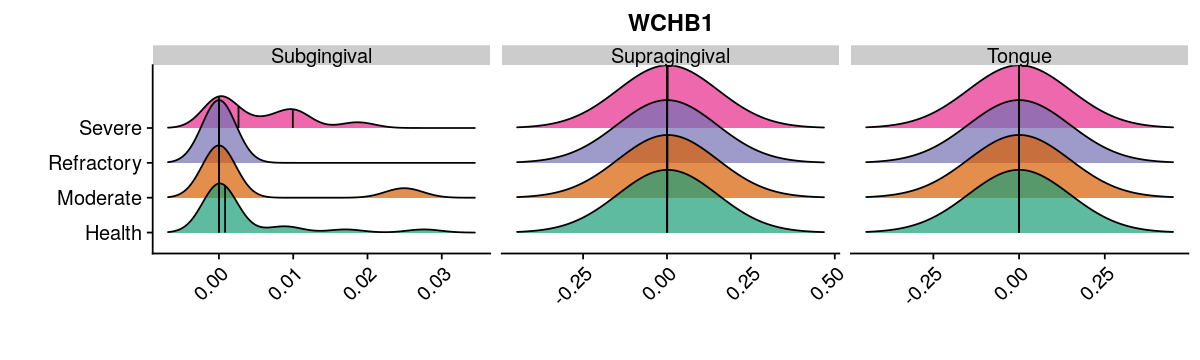

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.149
Picking joint bandwidth of 0.149


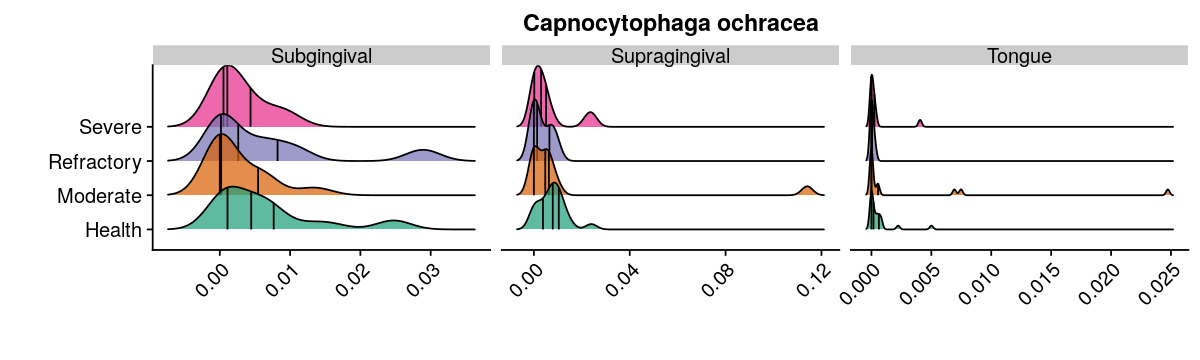

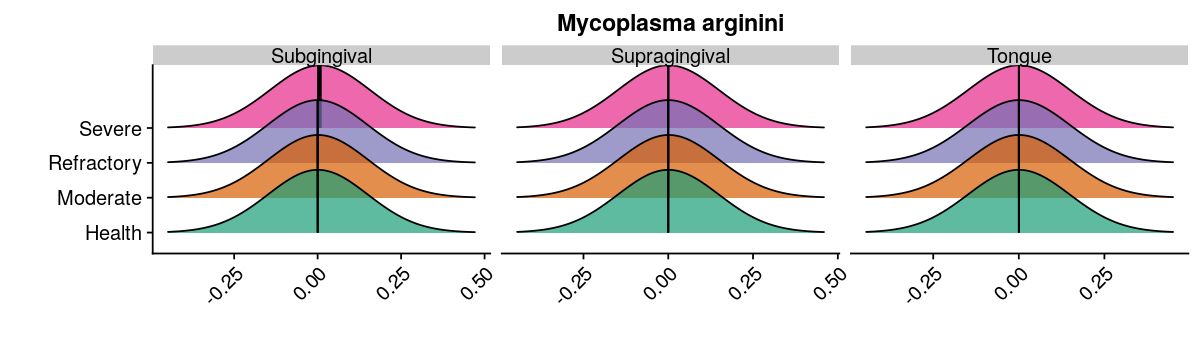

In [6]:
options(repr.plot.width=10, repr.plot.height=3)
plot_taxa('Centipeda', 'all')
plot_taxa('Fusobacterium', 'all')
plot_taxa('Prevotella oris', 'all')
plot_taxa('Catonella', 'all')
plot_taxa('Catonella morbi', 'all')
plot_taxa('Rothia', 'all')
plot_taxa('Solobacterium', 'all')
plot_taxa('Pasteurellaceae', 'all')
plot_taxa("Bergeyella", 'all')
plot_taxa('WCHB1', 'all')
plot_taxa('Capnocytophaga ochracea', 'all')
plot_taxa('Mycoplasma arginini', 'all')

## Bonus: Indicator ASV plots

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00373


Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00207


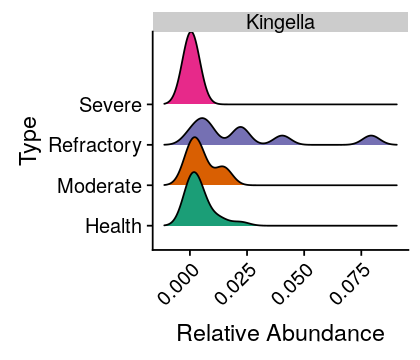

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00091


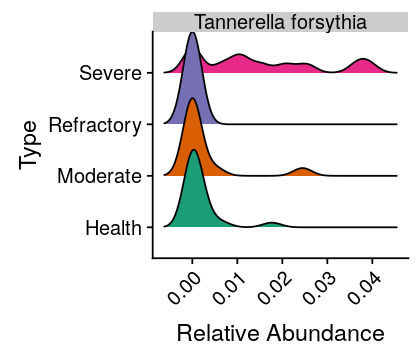

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.149


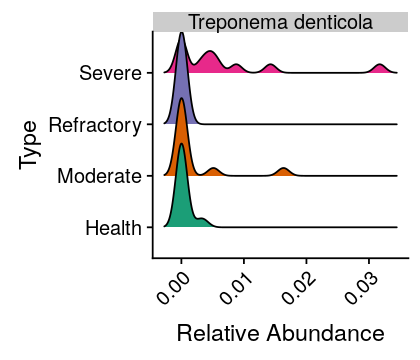

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000518


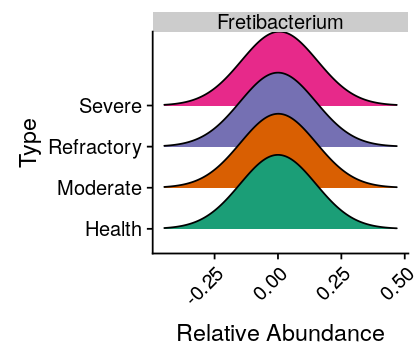

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000749


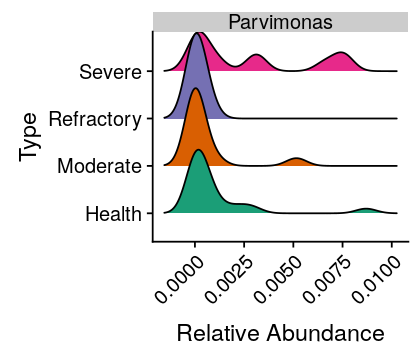

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.0118


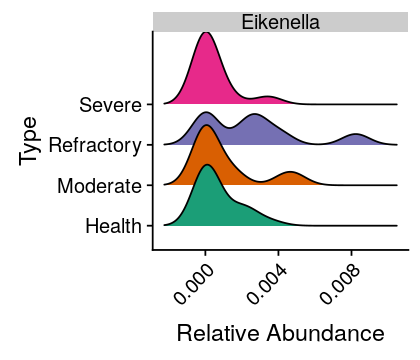

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00111


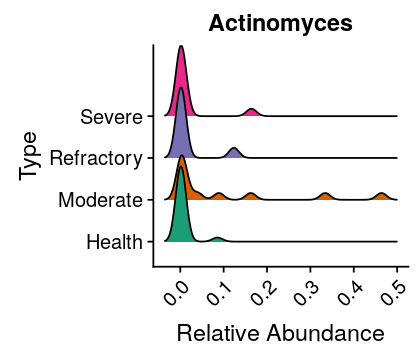

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00346


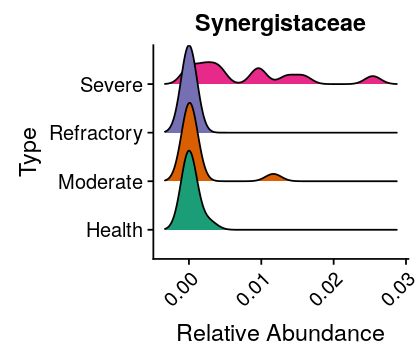

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00314


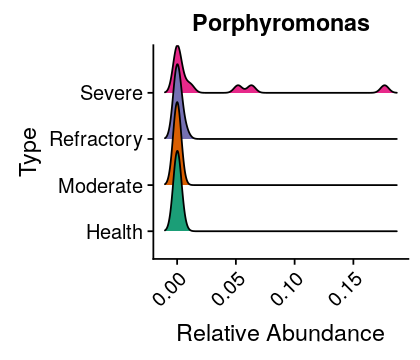

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00658


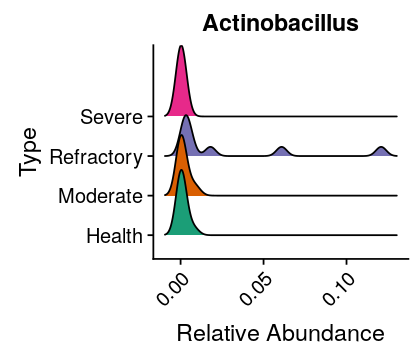

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000811


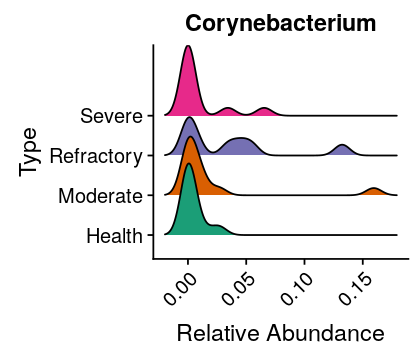

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00261


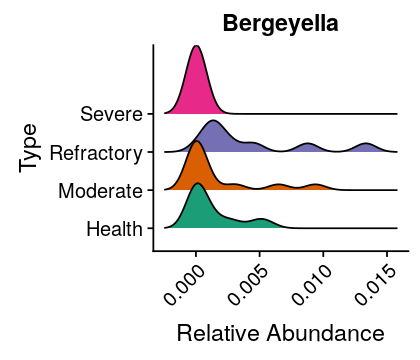

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00159


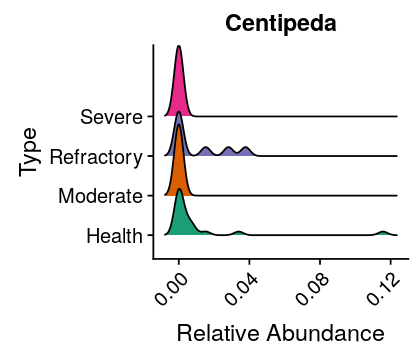

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 8.14e-05
Picking joint bandwidth of 0.000466


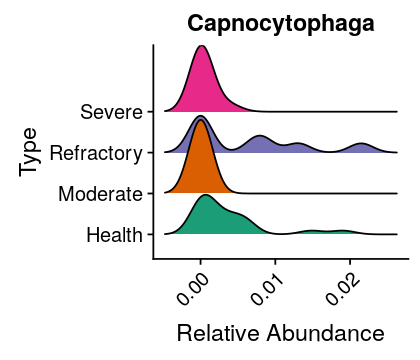

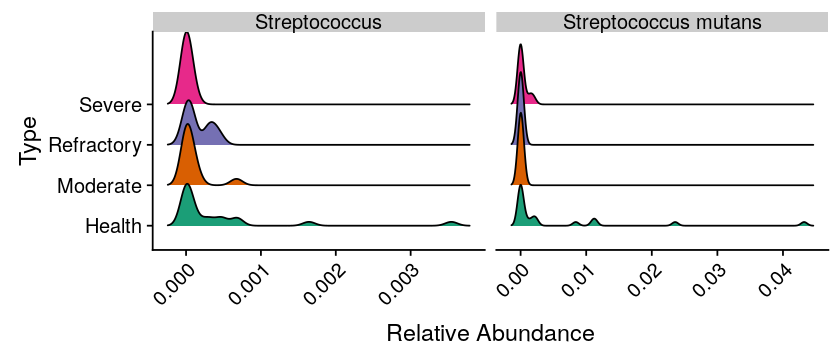

In [7]:
#Indicators, SUBG ONLY
options(repr.plot.width=3.5, repr.plot.height=3)
plot_indicators("Kingella", 'subg') + scale_color_grey()
plot_indicators("Tannerella forsythia", 'subg') + scale_color_grey()
plot_indicators("Treponema denticola", 'subg')+ scale_color_grey()
plot_indicators("Fretibacterium", 'subg')+ scale_color_grey()
plot_indicators("Parvimonas", 'subg')+ scale_color_grey()
plot_indicators("Eikenella", 'subg')+ scale_color_grey()
plot_combined_indicators("Actinomyces", 'subg')
plot_combined_indicators("Synergistaceae", 'subg')
plot_combined_indicators("Porphyromonas", 'subg')+ scale_color_grey()
plot_combined_indicators("Actinobacillus", 'subg')+ scale_color_grey()
plot_combined_indicators("Corynebacterium", 'subg')+ scale_color_grey()
plot_combined_indicators("Bergeyella", 'subg')
plot_combined_indicators("Centipeda", 'subg')
plot_combined_indicators("Capnocytophaga", 'subg')
options(repr.plot.width=7, repr.plot.height=3)
plot_indicators("Streptococcus", 'subg')

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.135
Picking joint bandwidth of 0.138


Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00631


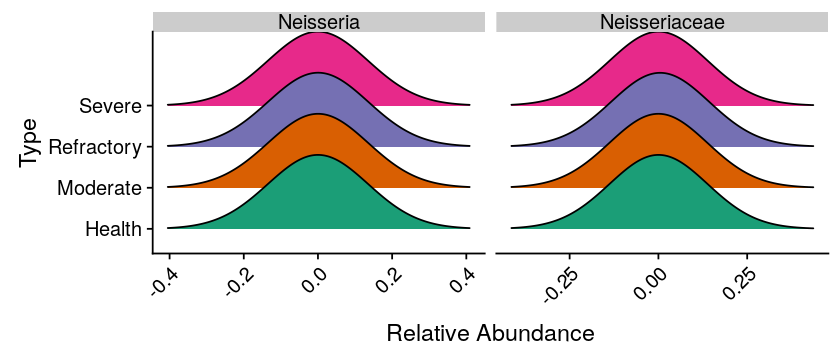

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 8e-04


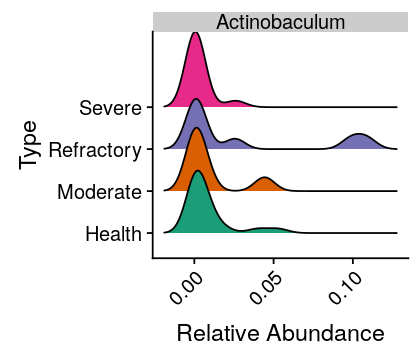

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.135


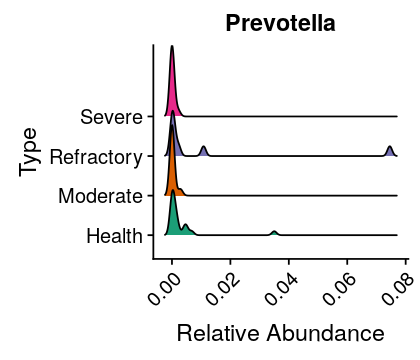

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.0096


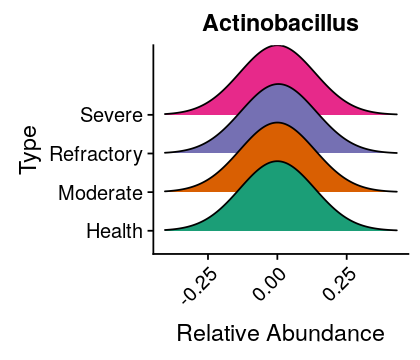

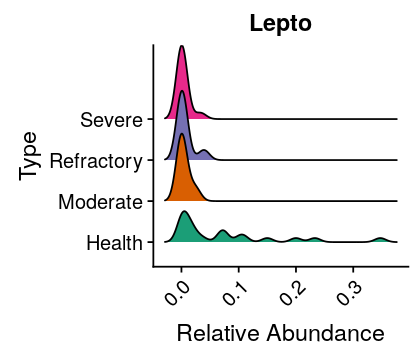

In [8]:
#Indicators, SUPG ONLY
options(repr.plot.width=7, repr.plot.height=3)
plot_indicators("Neisseria", 'supg')
options(repr.plot.width=3.5, repr.plot.height=3)
plot_indicators("Actinobaculum", 'supg')
plot_combined_indicators("Prevotella", 'supg')
plot_combined_indicators("Actinobacillus", 'supg')
plot_combined_indicators("Lepto", 'supg')

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000178
Picking joint bandwidth of 0.00037
Picking joint bandwidth of 0.000759
Picking joint bandwidth of 0.135


Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00509
Picking joint bandwidth of 0.00275


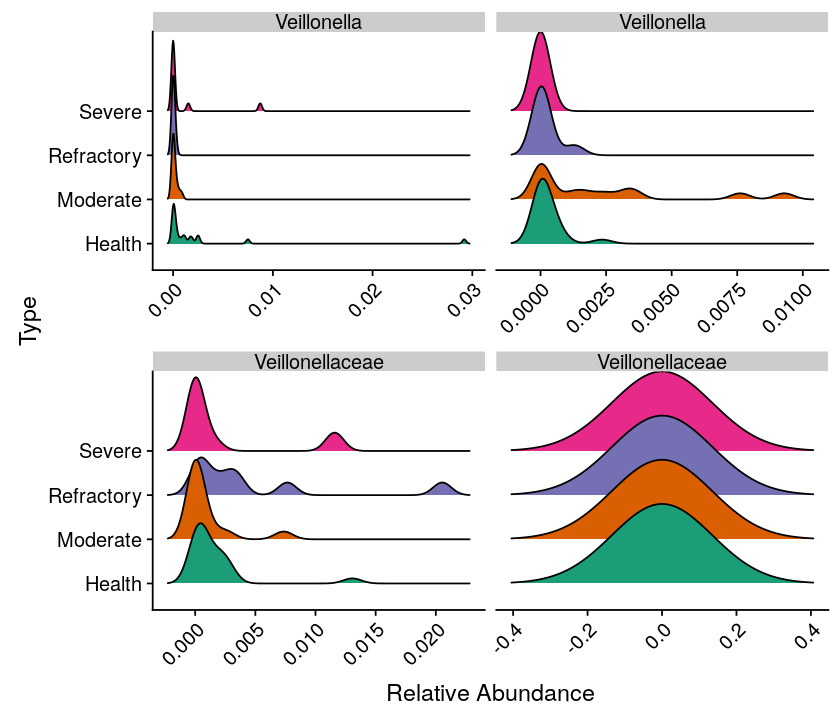

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00183


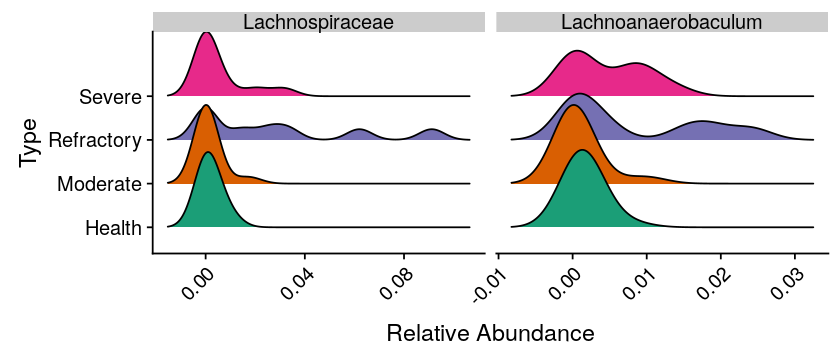

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000676


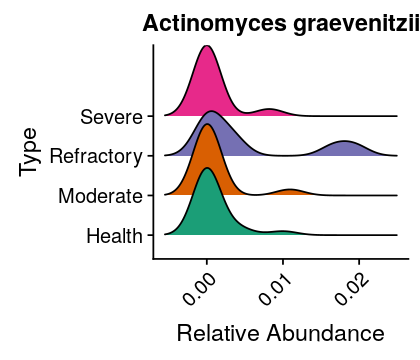

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000848


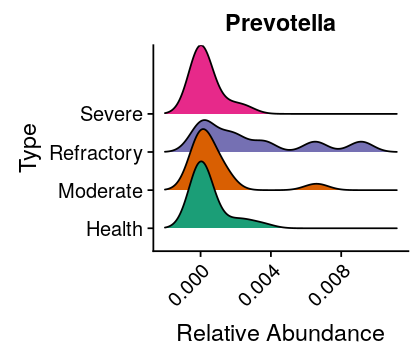

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000146


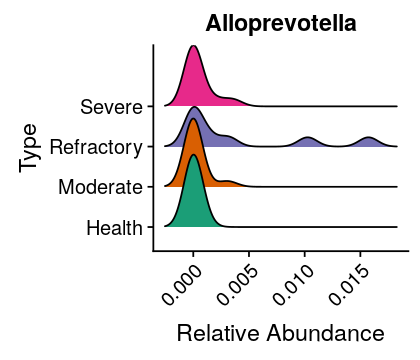

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.00258


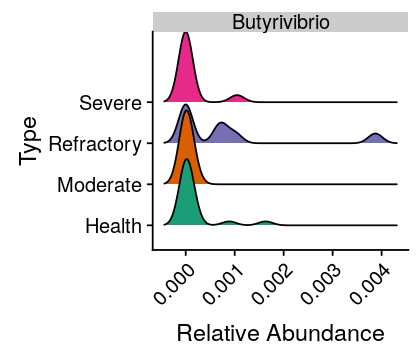

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.000327


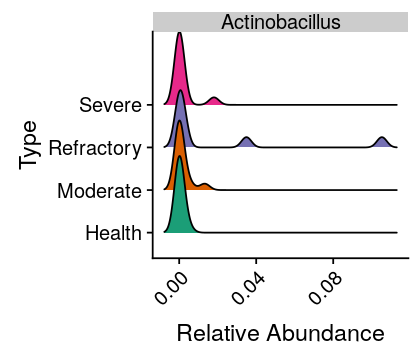

Using Feature.ID, Taxon as id variables
Picking joint bandwidth of 0.149


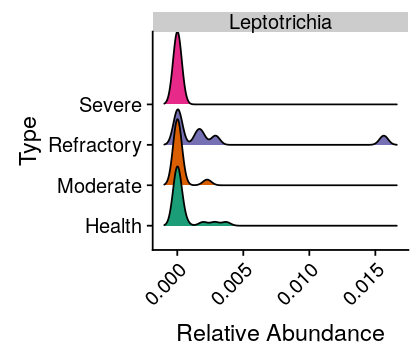

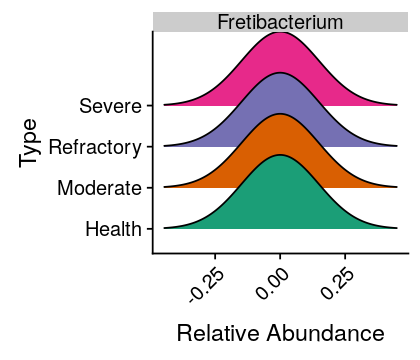

In [9]:
#Indicators, TONGUE ONLY
options(repr.plot.width=7, repr.plot.height=6)
plot_indicators("Veillonella", 'tongue')
options(repr.plot.width=7, repr.plot.height=3)
plot_indicators("Lachno", 'tongue')
options(repr.plot.width=3.5, repr.plot.height=3)
plot_combined_indicators("Actinomyces graevenitzii", 'tongue')
plot_combined_indicators("Prevotella", 'tongue')
plot_combined_indicators("Alloprevotella", 'tongue')
plot_indicators("Butyr", "tongue")
plot_indicators("Actinobacillus", 'tongue')
plot_indicators("Lepto", 'tongue')
plot_indicators("Fretibacterium", 'tongue')